#  Econ 570 Assignment 2 By Thomas Morissette

In This assignment I will be choosing the first three settings given by the instructor, namely:

1. Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates.

     a. You do not control for any covariates
 
     b. You control for all the covariates that affect the outcome
 
    
2. Simulate a DGP with a confounder (common cause)

    a. You fail to control for the confounder

    b. You do control for the confounder
    

3. Simulate a DGP with selection bias into the treatment (variable in between the path from the
treatment to the outcome)


   a. You control for the variable in between the path from cause to effect

   b. You do not control for the variable in between the path from cause to effect

### 1.Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates.


In [1]:
import os
import pandas as pd
import numpy as np
import random
import graphviz as gr
import statsmodels.api as sm
import matplotlib.pyplot as plt
import networkx as nx






   The first model is one of a regular treatment effect model with covariates but without a confounder variable as well as a Directed Acryllic Graph of the model where:
   
   - Y is the outcome variable
   - T is the treatment variable
   - X are the covariates
    



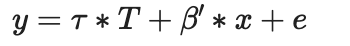

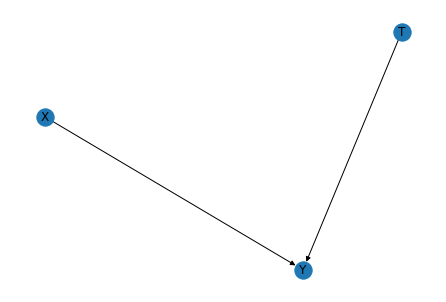

In [20]:
G = nx.DiGraph()
    
G.add_node('d1', desc='Y')
G.add_node('d2', desc='T')
G.add_node('d3', desc='X')
G.add_edge('d2','d1')
G.add_edge('d3','d1')
    
pos = nx.spring_layout(G)
nx.draw(G, pos )
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()


First we must simulate a random data generating process and store the generated data in a csv file that will be appended to this assignment. 

In [74]:
np.random.seed(300)
n = 1000
T = np.random.binomial(1, 0.5, n)
X = np.random.normal(1,5,n)
Y = np.random.normal(1 + 1*T + 1*X, 5).astype(int)
covariates = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
covariates.columns=["Treatment","Output","Covariate"]
covariates.to_csv("Covariates.csv", index=False)

We must now run two seperate Monte Carlo Simulations For the instances where:

- The covariates are not controlled 
- The covariates are controlled

This monte carlo simulation program will be used in all three portions of this assignment. 

## 1a. The Covariates are not being controlled

In [120]:
class MC_Simulator_1a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, B1, B2, n,sigma):
        """
        B1: intercept
        B2: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(1,5,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(B1 + B2*T + 1*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def Monte_Sim(self,B1,B2,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(B1,B2,n,sigma)
            B1_hat,B2_hat = self.estimate_ols_params(Y,T)
            y_hat = B1_hat + B2_hat * T
            treatment_effect = treatment_effect + [B2_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,B1,B2,n,sigma):
        bias, RMSE, treatment_effect = self.Monte_Sim(B1,B2,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]


In [121]:
N_100 = MC_Simulator_1a(10000)
res_100 = N_100.summarize_mc_simulation(1,1,100,1)
N_1000 = MC_Simulator_1a(10000)
res_1000 = N_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,0.940061,0.949610
RMSE,6.622067,6.701354
treatment effect,0.940061,0.949610


## 1b. The covariates are being controlled 

The only difference is the inclusion of the X covariate variable in the simulation of the data and the estimation of the OLS parameters. 

In [115]:
class MC_Simulator_1b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, B1,B2,B3, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(1,5,n)
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(B1 + B2*T + B3*X, 5).astype(int)
        
        return (Y,T,X)    
    
    def estimate_ols_params(self,Y,T,X):
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def Monte_Sim(self,B1,B2,B3,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(B1,B2,B3,n,sigma)
            B1_hat,B2_hat,B3_hat = self.estimate_ols_params(Y,T,X)
            y_hat = B1_hat + B2_hat * T + B3_hat*X
            treatment_effect = treatment_effect + [B2_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,B1,B2,B3,n,sigma):
        bias, RMSE, treatment_effect = self.Monte_Sim(B1,B2,B3,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [117]:
N_100 = MC_Simulator_1b(10000)
res_100 = N_100.summarize_mc_simulation(1,1,1,100,1)
N_1000 = MC_Simulator_1b(10000)
res_1000 = N_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,0.948974,0.949669
RMSE,4.670185,4.743184
treatment effect,0.950913,0.949561


There aremany real world situations in  which this model would be applicable such as:

- Y is Amount spent on Healthcare
- X is Age
- T is Provision of health insurance

## 2. Simulate a DGP with a confounder

Following the same process we generate random variables using the same funciton

In [98]:

np.random.seed(300)
n = 1000
T = np.random.binomial(1, 1/(1+X**2), n)
X = np.random.normal(1,5,n)
Y = np.random.normal(1 + 1*T + 1*X, 5).astype(int)
confounder = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
confounder.columns=["Treatment","Output","Covariate"]
confounder.to_csv("Confounder.csv", index=False)

Below is the DAG for the model with a confounder variable

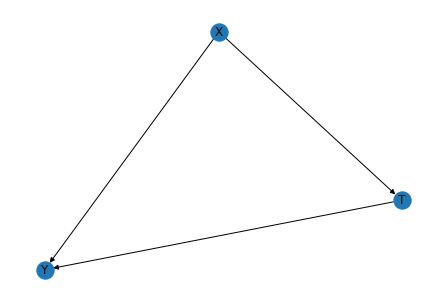

In [78]:
G = nx.DiGraph()
    
G.add_node('d1', desc='Y')
G.add_node('d2', desc='T')
G.add_node('d3', desc='X')
G.add_edge('d2','d1')
G.add_edge('d3','d1')
G.add_edge('d3','d2')
    
pos = nx.spring_layout(G)
nx.draw(G, pos )
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

# Monte Carlo  Simulations

## 2a. Failing to Control for confounder

In [79]:
class MC_Simulator_2a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, B1, B2, n,sigma):
        """
        B1: intercept
        B2: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(1,5,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(B1 + B2*T + 1*X, 5).astype(int)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def Monte_Sim(self,B1,B2,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(B1,B2,n,sigma)
            B1_hat,B2_hat = self.estimate_ols_params(Y,T)
            y_hat = B1_hat + B2_hat * T
            treatment_effect = treatment_effect + [B2_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,B1,B2,n,sigma):
        bias, RMSE, treatment_effect = self.Monte_Sim(B1,B2,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]



In [80]:

N_100 = MC_Simulator_2a(10000)
res_100 = N_100.summarize_mc_simulation(1,1,100,1)
N_1000 = MC_Simulator_2a(10000)
res_1000 = N_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,-0.117631,-0.121096
RMSE,6.613273,6.682007
treatment effect,-0.117631,-0.121096


## 2b. Controlling for Confounder

In [94]:
class MC_Simulator_2b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, B1,B2,B3, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        X = np.random.normal(1,5,n)
        T = np.random.binomial(1, 1/(1+X**2), n)
        Y = np.random.normal(B1 + B2*T + B3*X, 5).astype(int)
        
        return (Y,T,X)    
    
    def estimate_ols_params(self,Y,T,X):
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def Monte_Sim(self,B1,B2,B3,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(B1,B2,B3,n,sigma)
            B1_hat,B2_hat,B3_hat = self.estimate_ols_params(Y,T,X)
            y_hat = B1_hat + B2_hat * T + B3_hat*X
            treatment_effect = treatment_effect + [B2_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,B1,B2,B3,n,sigma):
        bias, RMSE, treatment_effect = self.Monte_Sim(B1,B2,B3,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [95]:
N_100 = MC_Simulator_2b(10000)
res_100 = N_100.summarize_mc_simulation(1,1,1,100,1)
N_1000 = MC_Simulator_2b(10000)
res_1000 = N_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,-0.123071,-0.117119
RMSE,4.660412,4.742446
treatment effect,0.904285,0.904057


An Example of the confounding effect could be the following:

- X is age
- T is Physical Activity
- Y is General Health

Age impacts both the general healthh of the person as well as their ability to perform physical activities. 

#  3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)


Once again we will simulate a GDP for selection bias:

In [99]:
np.random.seed(300)
n = 1000
T = np.random.binomial(1,0.5, n)
X = np.random.normal(1+ np.mean(T)*np.mean(Y),5,n)
Y = np.random.normal(1 + 1*T, 5).astype(int)
confounder = pd.DataFrame(dict(T = T,
                            X = X,
                            Y = Y))
confounder.columns=["Treatment","Output","Covariate"]
confounder.to_csv("Selection.csv", index=False)

The Selection Bias DAG is Illustrated Thusly:

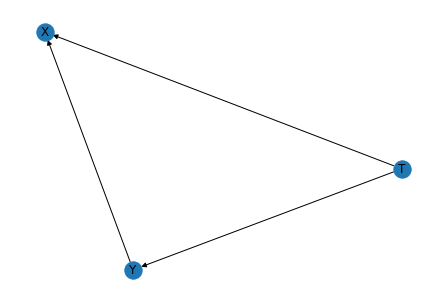

In [100]:
G = nx.DiGraph()
    
G.add_node('d1', desc='Y')
G.add_node('d2', desc='T')
G.add_node('d3', desc='X')
G.add_edge('d2','d1')
G.add_edge('d1','d3')
G.add_edge('d2','d3')
    
pos = nx.spring_layout(G)
nx.draw(G, pos )
node_labels = nx.get_node_attributes(G, 'desc')
nx.draw_networkx_labels(G, pos, labels=node_labels)
plt.show()

# Monte Carlo Simulations

## 3a.  You control for the variable in between the path from cause to effect

In [109]:
class MC_Simulator_3a():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, B1,B2,B3, n,sigma):
        """
        a: intercept
        b: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 1*T, 5).astype(int)
        X = np.random.normal(1+ np.mean(T)*np.mean(Y),5,n)
       
        
        return (Y,T,X)    
    
    def estimate_ols_params(self,Y,T,X):
        mod = sm.OLS(Y,sm.add_constant(pd.concat([pd.Series(T),pd.Series(X)],axis=1)))
        res = mod.fit()
        
        return res.params
    
    def Monte_Sim(self,B1,B2,B3,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T,X = self.simulate_data(B1,B2,B3,n,sigma)
            B1_hat,B2_hat,B3_hat = self.estimate_ols_params(Y,T,X)
            y_hat = B1_hat + B2_hat * T + B3_hat*X
            treatment_effect = treatment_effect + [B2_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,B1,B2,B3,n,sigma):
        bias, RMSE, treatment_effect = self.Monte_Sim(B1,B2,B3,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]

In [110]:
N_100 = MC_Simulator_3a(10000)
res_100 = N_100.summarize_mc_simulation(1,1,1,100,1)
N_1000 = MC_Simulator_3a(10000)
res_1000 = N_1000.summarize_mc_simulation(1,1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,N=100,N=1000
bias,0.936291,0.921936
RMSE,4.556183,4.629594
treatment effect,0.937753,0.922017


##  3b. You do not control for the variable in between the path from cause to effect

In [118]:
class MC_Simulator_3b():
    
    def __init__(self,n_rep):
        """
        n_rep: number of MC replications
        """
        self.n_rep = n_rep
    def simulate_data(self, B1, B2, n,sigma):
        """
        B1: intercept
        B2: slope of treatment dummy variable
        n: sample size
        sigma: error variance
        Y = a+b*T+e
        """
        T = np.random.binomial(1, 0.5, n)
        Y = np.random.normal(1 + 1*T, 5).astype(int)
        X = np.random.normal(1+ np.mean(T)*np.mean(Y),5,n)
        
        return (Y,T)    
    
    def estimate_ols_params(self,Y,T):
        mod = sm.OLS(Y,sm.add_constant(T))
        res = mod.fit()
        
        return res.params
    
    def Monte_Sim(self,B1,B2,n,sigma):
        
        treatment_effect = []
        bias = []
        RMSE = []
        for rep in range(self.n_rep):
            Y,T = self.simulate_data(B1,B2,n,sigma)
            B1_hat,B2_hat = self.estimate_ols_params(Y,T)
            y_hat = B1_hat + B2_hat * T
            treatment_effect = treatment_effect + [B2_hat]
            bias = bias + [np.mean(Y[T==1])-np.mean(Y[T==0])]
            RMSE = RMSE + [np.sqrt(np.mean((Y-y_hat)**2))]
        return bias, RMSE, treatment_effect
    
    def summarize_mc_simulation(self,B1,B2,n,sigma):
        bias, RMSE, treatment_effect = self.Monte_Sim(B1,B2,n,sigma)
        return [np.mean(bias),np.mean(RMSE),np.mean(treatment_effect)]



In [119]:
N_100 = MC_Simulator_3b(10000)
res_100 = N_100.summarize_mc_simulation(1,1,100,1)
N_1000 = MC_Simulator_3b(10000)
res_1000 = N_1000.summarize_mc_simulation(1,1,1000,1)
res = pd.concat([pd.Series(res_100),pd.Series(res_1000)],axis = 1)
res.columns = [['N=100','N=1000']]
res.index = [['bias','RMSE','treatment effect']]
res

,N=100,N=1000
bias,0.923282,0.923429
RMSE,4.576494,4.634170
treatment effect,0.923282,0.923429


Selection Bias Real World Example:

- X: Hospitalization
- T: Age
- Y: Lung Disease

Age Influences both the rates of hospitalization as well as. the rates of lung disease leading to hospitalization. 